In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats

DIR = "/home/julian/Documents/ndnrtc_testing/evaluation/reTrans_evaluation_results"

# read in csv file
df = pd.read_csv(DIR + '/run_overview.csv', delimiter='\t', index_col=False)

# transform columns names to lower case
df.columns = [col.lower() for col in df]

# ensuring backwards compatibility
df.rename(columns={"adaption":"init._res."}, inplace=True)

# ensuring forwards compatibility
df.rename(columns={"retr._total":"retransmissions", 
                   "al_seq.len.":"al_seq_len"}, inplace=True)

# remove unnecessary columns
df.drop(columns=["retr._max"], inplace=True)

df.head()

,setting,run,init._res.,adaption_logic,shaping_profile,bandwith(cons),al_w1,al_w2,al_th1,al_th2,al_seq_len,frames_missing,retransmissions,psnr,ssim,vmaf
0,1,0,med,ReTrans,HLH,-----,0.7,1.3,1,3,1,1051,931,15.23,0.694953,38.218117
1,1,1,med,ReTrans,HLH,-----,0.7,1.3,1,3,1,976,500,19.19,0.677450,37.759937
2,1,2,med,ReTrans,HLH,-----,0.7,1.3,1,3,1,646,595,16.27,0.573160,38.615331
3,1,3,med,ReTrans,HLH,-----,0.7,1.3,1,3,1,506,832,14.65,0.574026,38.893652
4,1,4,med,ReTrans,HLH,-----,0.7,1.3,1,3,1,527,1339,15.11,0.535138,39.707945


In [2]:
def customFilter (df, al_w1_fixed, al_w2_fixed, al_th1_fixed, al_th2_fixed, al_seq_len_fixed):
   
    # filter data according to fixed parameters
    df_tmp = df[(df.al_w1 == al_w1_fixed) 
             & (df.al_w2 == al_w2_fixed)
             & (df.al_th1 == al_th1_fixed) 
             & (df.al_th2 == al_th2_fixed)
             & (df.al_seq_len == al_seq_len_fixed)]
    
    return df_tmp

def customFilter2 (df, adaption_logic, init_res, shaping_profile):
   
    # filter data according to fixed parameters
    df_tmp = df[(df.adaption_logic == adaption_logic) 
                & (df["init._res."] == init_res)
                & (df.shaping_profile == shaping_profile)]
    
    return df_tmp

In [3]:
def prepareDataforWinnerAdvantagePlot(metric):
    
    # prepare columns and index for new dataframe
    columns=["low", "med", "high", "reTrans"]
    index = pd.MultiIndex.from_product([["mean", "std"], ["HL", "LH", "HLH", "LHL"]], 
                                       names=["type", "shaping_profile"])
    # create new dataframe
    df_data = pd.DataFrame(index =index, columns=columns) 
    
    # fill data frame with values
    for init_res in df_data.columns:
            
        # reTrans needs additional filtering
        if init_res == "reTrans":
            # get only rows with the chosen parameters (winning setting)
            tmp = customFilter(df, 0.7, 1.3, 1, 3, 5)
            for shaping_profile in df_data.index.get_level_values('shaping_profile').unique():
                                 
                df_data.at[("mean", shaping_profile), init_res] = customFilter2(
                    tmp, "ReTrans", "med", shaping_profile)[metric].mean()
               
                df_data.at[("std", shaping_profile), init_res] = customFilter2(
                    tmp, "ReTrans", "med", shaping_profile)[metric].std()
        else:     
            for shaping_profile in df_data.index.get_level_values('shaping_profile').unique():
                      
                df_data.at[("mean", shaping_profile), init_res] = customFilter2(
                    df, "NoAdaption", init_res, shaping_profile)[metric].mean()
               
                df_data.at[("std", shaping_profile), init_res] = customFilter2(
                    df, "NoAdaption", init_res, shaping_profile)[metric].std()
      
    return df_data

In [4]:
def drawWinnerAdvantagePlot(metric):
    
    # get data for plot
    data = prepareDataforWinnerAdvantagePlot(metric)
    
    # prepare some variables & parameters for plotting
    fig, ax = plt.subplots()
    positions = np.array([0,5,10,15])
    group_colors=["lightsalmon", "chocolate", "saddlebrown", "royalblue"]
    topx = len(data.index)
    xlabels = []
    
    # draw bars for each of the groups
    for x in range(0, len(data.columns)):
        
        # prepare some additional parameters
        pos = positions + x
        values = data[data.columns[x]]["mean"]
        errors = data[data.columns[x]]["std"]
        label = data.columns[x]
        color = group_colors[x]
        
        # draw bar with error markers
        rect = ax.bar(pos, values, width=1, yerr=errors, label=label, color=color, edgecolor="black", capsize=3)
        
    #some adjustments for better readability
#    if metric == "psnr":
#        ax.set_ylim(0, 40) # 20
#    if metric == "ssim":
#        ax.set_ylim(0, 1) # 0.7
#    if metric == "vmaf":
#        ax.set_ylim(0, 51) 
#    if metric == "retransmissions":
#        ax.set_ylim(0, 1000)    
#    if metric == "frames_missing":
#        ax.set_ylim(0, 900)
    
    # add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(metric)
    ax.set_title('Comparison: No Adaption vs. ReTrans (Winning Setting)')
    ax.set_xticks([1.5,6.5,11.5,16.5])
    ax.set_xticklabels(data.index.get_level_values(1).unique())
    ax.legend()
    plt.tight_layout()
    
    # save created plot as a pdf
    plt.savefig(DIR + "/reTrans_winneradvantage_" + metric + "_comparison" + ".pdf")

In [5]:
def drawWinnerAdvantagePlots():
    drawWinnerAdvantagePlot("psnr")
    drawWinnerAdvantagePlot("ssim")
    drawWinnerAdvantagePlot("vmaf")
    drawWinnerAdvantagePlot("retransmissions")
    drawWinnerAdvantagePlot("frames_missing")

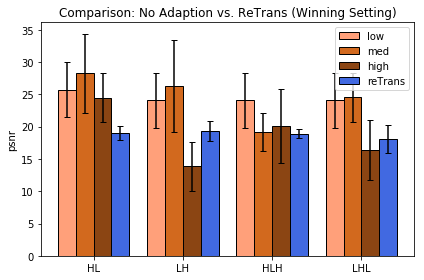

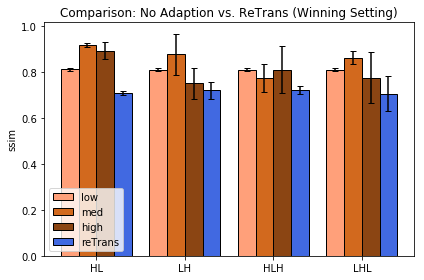

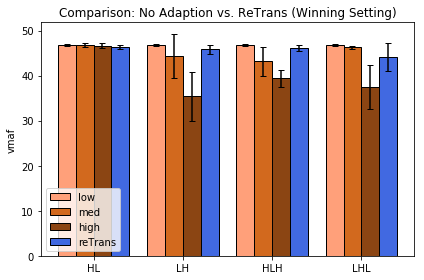

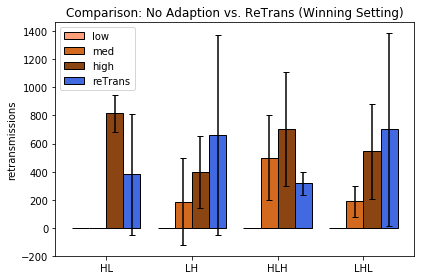

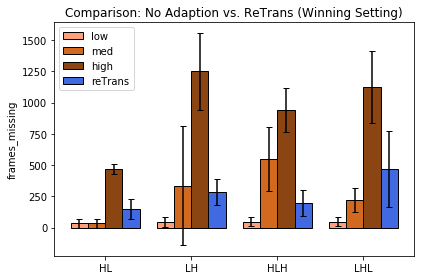

In [6]:
drawWinnerAdvantagePlots()